In [105]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
is_out_exist = os.path.exists('out')
if not is_out_exist:
    os.makedirs('out')
    print("The new directory is created!")

In [106]:
def generate_search_window(i,j,p, shape):
    lu = (max(0, i-p-1), max(0, j-p-1))               #i-p, j-p
    ld = (min(shape[0], i+p), max(0, j-p-1))        #i+p, j-p
    ru = (max(0, i-p-1), min(shape[1], j+p))        #i-p, j+p
    rd = (min(shape[0], i+p), min(shape[1], j+p)) #i+p, j+p
    return lu, ld, ru, rd
def SAD(window, blk):
    return np.sum(np.abs(window-blk))
def full_search          (reference_image, target_image,u,v,p, N):
    min_SAD = 100000000000000
    u_goto = 0
    v_goto = 0
    max_row = reference_image.shape[0]
    max_col = reference_image.shape[1]
    for i in range(-p, p+1):
        for j in range(-p, p+1):
            ref_lu_corner = (i+u,j+v)
            if ref_lu_corner[0] < 0 or ref_lu_corner[1] < 0 or ref_lu_corner[0]+N > max_row or ref_lu_corner[1]+N > max_col:
                continue
            tmp = SAD(target_image[u:u+N,v:v+N,:], reference_image[ref_lu_corner[0]:ref_lu_corner[0]+N, ref_lu_corner[1]:ref_lu_corner[1]+N, :])
            if tmp < min_SAD:
                min_SAD = tmp
                u_goto = i
                v_goto = j
    return u_goto, v_goto
def logarithmic_search_2d(reference_image, target_image,u,v,p, N):
    #print('at', p, 'u,v=',u,v)
    min_SAD = 100000000000000
    u_goto = 0
    v_goto = 0
    max_row = reference_image.shape[0]
    max_col = reference_image.shape[1]
    for i in [-p, 0, p+1]:
        for j in [-p, 0, p+1]:
            ref_lu_corner = (i+u,j+v)
            if ref_lu_corner[0] < 0 or ref_lu_corner[1] < 0 or ref_lu_corner[0]+N > max_row or ref_lu_corner[1]+N > max_col:
                continue
            tmp = SAD(target_image[u:u+N,v:v+N,:], reference_image[ref_lu_corner[0]:ref_lu_corner[0]+N, ref_lu_corner[1]:ref_lu_corner[1]+N, :])
            if tmp < min_SAD:
                min_SAD = tmp
                u_goto = i
                v_goto = j
    if p == 1:
        return u+u_goto, v+v_goto
    else:
        return logarithmic_search_2d(reference_image, target_image,u+u_goto,v+v_goto,int(p/2), N)
def my_motion_estimation(reference_image_name, target_image_name, N, p, approach):
    reference_image = cv2.imread(reference_image_name, cv2.IMREAD_COLOR)
    target_image = cv2.imread(target_image_name, cv2.IMREAD_COLOR)
    motion_vectors = np.zeros((int(reference_image.shape[0]/N), int(reference_image.shape[1]/N), 2))
    residual_image = np.zeros((reference_image.shape[0], reference_image.shape[1], 3))
    predicted_image = np.zeros((reference_image.shape[0], reference_image.shape[1], 3))
    max_row = reference_image.shape[0]
    max_col = reference_image.shape[1]
    for u in range(0,max_row, N):
        for v in range(0, max_col, N):
            if approach == 'full':
                u_goto, v_goto = full_search          (reference_image, target_image,u,v,p,N)
                motion_vectors[int(u/N), int(v/N)] = (u_goto, v_goto)
                #print(u+u_goto, u+u_goto+N, v+v_goto, v+v_goto+N)
                #print(reference_image[u+u_goto:u+u_goto+N, v+v_goto:v+v_goto+N, : ].shape, reference_image.shape)            
                predicted_image[u:u+N, v:v+N,:] = reference_image[u+u_goto:u+u_goto+N, v+v_goto:v+v_goto+N, : ].copy()
            else:
                u_goto, v_goto = logarithmic_search_2d(reference_image, target_image,u,v,p,N)
                motion_vectors[int(u/N), int(v/N)] = (u_goto-u, v_goto-v)
                predicted_image[u:u+N, v:v+N,:] = reference_image[u_goto:u_goto+N, v_goto:v_goto+N, : ].copy()
    #print(motion_vectors)
    residual_image = target_image - predicted_image
    return motion_vectors, residual_image, predicted_image, SAD(target_image, predicted_image), PSNR(target_image, predicted_image)
def draw_arrow_line(estimated_motion, reference_image_name, N, vector_image_name):
    img = cv2.imread(reference_image_name, cv2.IMREAD_COLOR)
    for i in range(0,img.shape[0], N):
        for j in range(0,img.shape[1], N):
            start = (i,j)
            end = (int(i+estimated_motion[int(i/N), int(j/N)][0]),int(j + estimated_motion[int(i/N), int(j/N)][1]))
            
            start = (start[1], start[0])
            end = (end[1], end[0])
            cv2.arrowedLine(img, end, start, (0,0,225))
    cv2.imwrite(vector_image_name, img)
    #cv2.imshow('arrow line image', img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
def draw_residual(residual_image, residul_image_name):
    gray_residual = np.zeros((residual_image.shape[0], residual_image.shape[1],1))
    for i in range(residual_image.shape[0]):
        for j in range(residual_image.shape[1]):
            gray_residual[i,j] = 0.2989*residual_image[i,j,0] + 0.5870*residual_image[i,j,1] + 0.1140*residual_image[i,j,2]
    cv2.imwrite(residul_image_name, residual_image)
def draw_predicted_image(predicted_image, predicted_image_name):
    cv2.imwrite(predicted_image_name, predicted_image)
    #cv2.imshow('predicted image', predicted_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
def MSE(img1, img2):
    img1 = np.array(img1, dtype=np.float64)
    img2 = np.array(img2, dtype=np.float64)
    return np.mean((img1 - img2) ** 2)
def PSNR(img, res):
    sigma = MSE(img, res)
    snr = 10*np.log10(np.max(img)**2/sigma)
    return snr
def draw_psnr_sad(data_lib, reference_image_name, target_image_name):
    N = [8, 8, 16, 16]
    p = [8, 16, 8, 16]
    full = [data_lib['full'][8,8], data_lib['full'][8,16], data_lib['full'][16,8], data_lib['full'][16,16]]
    twod = [data_lib['2d'][8,8], data_lib['2d'][8,16], data_lib['2d'][16,8], data_lib['2d'][16,16]]
    show_type = {'psnr':0, 'sad':1}
    for k, v in show_type.items():
        tmp_full = []
        tmp_twod = []
        if k == 'psnr':
            for i in range(len(full)):
                tmp_full.append(full[i][1])
                tmp_twod.append(twod[i][1])
        else:
            for i in range(len(full)):
                tmp_full.append(full[i][0])
                tmp_twod.append(twod[i][0])
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.xaxis.labelpad = 5
        ax.yaxis.labelpad = 15
        ax.zaxis.labelpad = -1
        ax.scatter(N, p, tmp_full, c='r', marker='o', label='full search')
        ax.scatter(N, p, tmp_twod, c='b', marker='^', label='2d log search')
        ax.legend()
        ## Set the axis labels
        ax.set_xlabel('N', rotation=0)
        ax.set_ylabel('p', rotation=0)
        ax.set_zlabel(k  , rotation=90)
        ax.set_title(k+' of '+reference_image_name+' and '+target_image_name)
        plt.savefig('out\\'+k+'_'+reference_image_name+'_'+target_image_name+'.jpg')
        ## Show the plot
        plt.show()

In [113]:
reference_image_name = '.\\img\\40.jpg'
target_image_name    = '.\\img\\42.jpg'

In [114]:
data_lib = {'full':{}, '2d':{}} # data_lib[approach][N][p] = (SAD, PSNR)
for approach in ['full','2d']:
    for N in [8, 16]:
        for p in [8, 16]:
            estimated_motion, residual_image, predicted_image, sad_value, psnr_value = my_motion_estimation(reference_image_name=reference_image_name, target_image_name=target_image_name, N=N, p=p, approach=approach)
            vector_image_name = 'out\\'+approach+'_motion_vector_r'+str(p)+'_b'+str(N)+'.jpg'
            residual_image_name = 'out\\'+approach+'_residual_r'+str(p)+'_b'+str(N)+'.jpg'
            predicted_image_name = 'out\\'+approach+'_predicted_r'+str(p)+'_b'+str(N)+'.jpg'
            print('approach: ', approach, 'N: ', N, 'p: ', p, 'SAD: ', sad_value, 'PSNR: ', psnr_value)
            data_lib[approach][(N,p)] = (sad_value, psnr_value)
            draw_residual(residual_image, residul_image_name=residual_image_name)
            draw_arrow_line(estimated_motion, target_image_name, N=N, vector_image_name=vector_image_name)
            draw_predicted_image(predicted_image, predicted_image_name=predicted_image_name)

approach:  full N:  8 p:  8 SAD:  42782373.0 PSNR:  19.325764646396262
approach:  full N:  8 p:  16 SAD:  44348488.0 PSNR:  19.43705831450481
approach:  full N:  16 p:  8 SAD:  44604168.0 PSNR:  18.967187538844943
approach:  full N:  16 p:  16 SAD:  51056382.0 PSNR:  18.45081826241924
approach:  2d N:  8 p:  8 SAD:  65088101.0 PSNR:  17.015099391330942
approach:  2d N:  8 p:  16 SAD:  77253020.0 PSNR:  16.02899965940812
approach:  2d N:  16 p:  8 SAD:  65006158.0 PSNR:  16.999737214554024
approach:  2d N:  16 p:  16 SAD:  77371015.0 PSNR:  15.959778605185551


{'full': {(8, 8): (42782373.0, 19.325764646396262), (8, 16): (44348488.0, 19.43705831450481), (16, 8): (44604168.0, 18.967187538844943), (16, 16): (51056382.0, 18.45081826241924)}, '2d': {(8, 8): (65088101.0, 17.015099391330942), (8, 16): (77253020.0, 16.02899965940812), (16, 8): (65006158.0, 16.999737214554024), (16, 16): (77371015.0, 15.959778605185551)}}


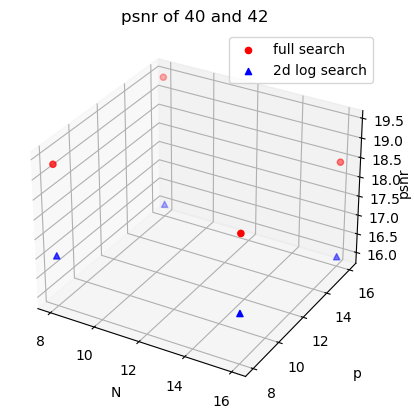

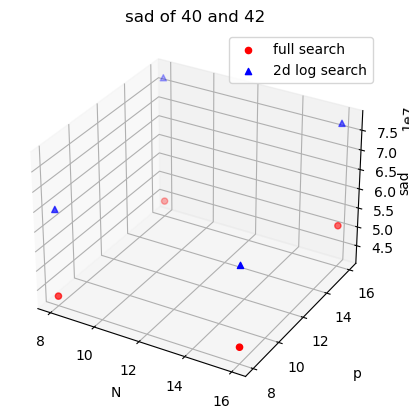

In [115]:
print(data_lib)
draw_psnr_sad(data_lib, '40', '42')

In [110]:
reference_image_name = '.\\img\\40.jpg'
target_image_name    = '.\\img\\51.jpg'

In [111]:

data_lib = {'full':{}, '2d':{}} # data_lib[approach][N][p] = (SAD, PSNR)
for approach in ['full','2d']:
    for N in [8,16]:
        for p in [8,16]:
            estimated_motion, residual_image, predicted_image, sad_value, psnr_value = my_motion_estimation(reference_image_name=reference_image_name, target_image_name=target_image_name, N=N, p=p, approach=approach)
            vector_image_name = 'out\\'+approach+'_motion_vector_r'+str(p)+'_b'+str(N)+'.jpg'
            residual_image_name = 'out\\'+approach+'_residual_r'+str(p)+'_b'+str(N)+'.jpg'
            predicted_image_name = 'out\\'+approach+'_predicted_r'+str(p)+'_b'+str(N)+'.jpg'
            print('approach: ', approach, 'N: ', N, 'p: ', p, 'SAD: ', sad_value, 'PSNR: ', psnr_value)
            data_lib[approach][(N,p)] = (sad_value, psnr_value)
            draw_residual(residual_image, residul_image_name=residual_image_name)
            draw_arrow_line(estimated_motion, target_image_name, N=N, vector_image_name=vector_image_name)
            draw_predicted_image(predicted_image, predicted_image_name=predicted_image_name)

approach:  full N:  8 p:  8 SAD:  57246561.0 PSNR:  17.452878227690338
approach:  full N:  8 p:  16 SAD:  52896101.0 PSNR:  17.806378413786735
approach:  full N:  16 p:  8 SAD:  60065389.0 PSNR:  17.151993179235653
approach:  full N:  16 p:  16 SAD:  58604683.0 PSNR:  17.21593783831391
approach:  2d N:  8 p:  8 SAD:  69718257.0 PSNR:  16.26498435511055
approach:  2d N:  8 p:  16 SAD:  77856846.0 PSNR:  15.556119495070003
approach:  2d N:  16 p:  8 SAD:  72702512.0 PSNR:  16.030206359727867
approach:  2d N:  16 p:  16 SAD:  81905843.0 PSNR:  15.283551960175359


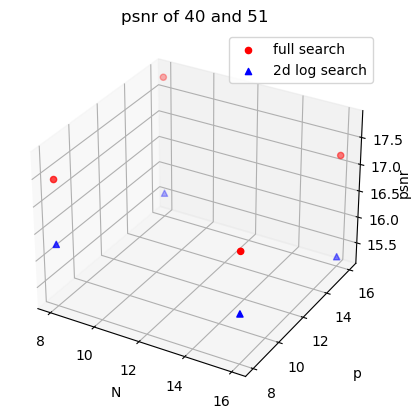

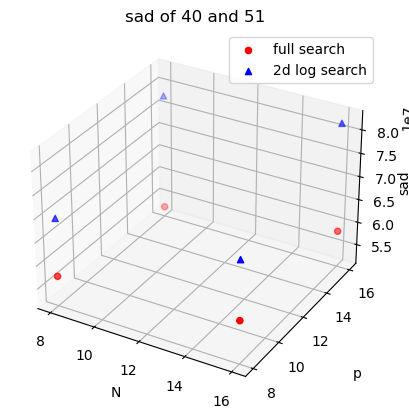

In [112]:
draw_psnr_sad(data_lib, '40', '51')